## Helper functions

In [56]:
import subprocess
import torch

# https://pytorch.org/get-started/locally/

def get_cuda_info():
    print("NVIDIA Graphics Card Driver: ", subprocess.getoutput("nvidia-smi")[:980])
    print("CUDA version: ", subprocess.getoutput("nvcc --version"), "\n")

def get_torch_info():
    print(subprocess.getoutput("pip show torch"), "\n")

def get_device(show_info = True):
    if torch.cuda.is_available():    
        device = torch.device("cuda")

        if show_info:
            print('There are %d GPU(s) available.' % torch.cuda.device_count())
            print('We will use the GPU:', torch.cuda.get_device_name(0))

    else:
        device = torch.device("cpu")

        if show_info:
            print('No GPU available, using the CPU instead.')

    return device

## Small Pytorch examples

In [25]:
import torch
import torch.nn as nn

LR = 0.005
EPOCHS = 1

class DiffusedSLI(nn.Module):
    def __init__(self):
        super(DiffusedSLI, self).__init__()
        self.w = nn.Linear(1, 1, bias=False)

    def forward(self, S: torch.Tensor, L: torch.Tensor, I: torch.Tensor):
        I = S.add(L).add(I)
        I = self.w(I)
        return S, L, I

device = get_device()
model = DiffusedSLI().to(device)
loss = nn.MSELoss()

print(*model.parameters(), "\n")
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

S = torch.ones(100, 1, dtype=torch.float32).to(device)
L = torch.ones(100, 1, dtype=torch.float32).to(device)
I = torch.ones(100, 1, dtype=torch.float32).to(device)
I_obs = torch.ones(100, 1, dtype=torch.float32).to(device) * 6

for epoch in range(EPOCHS):
    for time_step in range(201):
        _, _, I_pred = model(S, L, I)

        l = loss(I_pred, I_obs)

        if time_step % 50 == 0: print(model.w.weight, l.item(), "\n")

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 with Max-Q Design
Parameter containing:
tensor([[-0.1860]], device='cuda:0', requires_grad=True) 

Parameter containing:
tensor([[-0.1860]], device='cuda:0', requires_grad=True) 43.00661849975586 

Parameter containing:
tensor([[1.9804]], device='cuda:0', requires_grad=True) 0.003448835574090481 

Parameter containing:
tensor([[1.9998]], device='cuda:0', requires_grad=True) 2.766248314856057e-07 

Parameter containing:
tensor([[2.0000]], device='cuda:0', requires_grad=True) 2.2737367544323206e-11 

Parameter containing:
tensor([[2.0000]], device='cuda:0', requires_grad=True) 3.637978807091713e-12 



In [23]:
import torch
import torch.nn as nn

LR = 0.005
EPOCHS = 1

class DiffusedSLI(nn.Module):
    def __init__(self):
        super(DiffusedSLI, self).__init__()
        self.w = nn.Linear(1, 1, bias=False)

    def forward(self, S: torch.Tensor, L: torch.Tensor, I: torch.Tensor):
        I = S.add(L).add(I)
        I = self.w(I)
        return S.clone().detach(), L.clone().detach(), I.clone().detach(), I

device = get_device()
model = DiffusedSLI().to(device)
loss = nn.MSELoss()

print(*model.parameters(), "\n")
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

S = torch.ones(100, 1, dtype=torch.float32).to(device)
L = torch.ones(100, 1, dtype=torch.float32).to(device)
I = torch.ones(100, 1, dtype=torch.float32).to(device)
I_obs = torch.ones(100, 1, dtype=torch.float32).to(device) * 6

for epoch in range(EPOCHS):
    for time_step in range(201):
        S, L, I, I_pred = model(S, L, I)

        l = loss(I_pred, I_obs)

        I = torch.ones(100, 1, dtype=torch.float32).to(device)

        if time_step % 50 == 0: print(model.w.weight, l.item(), "\n")

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

No GPU available, using the CPU instead.
Parameter containing:
tensor([[0.7199]], requires_grad=True) 

Parameter containing:
tensor([[0.7199]], requires_grad=True) 14.74898910522461 

Parameter containing:
tensor([[1.9885]], requires_grad=True) 0.0011828014394268394 

Parameter containing:
tensor([[1.9999]], requires_grad=True) 9.488667274126783e-08 

Parameter containing:
tensor([[2.0000]], requires_grad=True) 5.6843418860808015e-12 

Parameter containing:
tensor([[2.0000]], requires_grad=True) 3.637978807091713e-12 



## Diffused SLI model implementation in Pytorch

### Initialization of delta_x, delta_t, delta_h matrix

In [93]:
import numpy as np

delta_x = 0.1
delta_t = delta_x**2 / 2
max_x = 20
max_t = 15

x = np.arange(0, max_x + delta_x, delta_x)
t = np.arange(0, max_t + delta_t, delta_t)
size_x = x.size
size_t = t.size
print(size_x, size_t)

# Diffusion matrix
delta_h = np.eye(size_x, size_x, 0) * -2 \
            + np.eye(size_x, size_x, -1) \
            + np.eye(size_x, size_x, 1)
# Dyrichlet BC on the left side
delta_h[0][0] = 0
delta_h[0][1] = 0
# Neumann BC on the right side
delta_h[-1][-2] = 2
# delta_h

201 3001


### Use ocurrence of infection as expected output

In [ ]:
import torch
import torch.nn as nn

LR = 0.005
EPOCHS = 1

class DiffusedSLI(nn.Module):
    def __init__(self, add_diffusion=False, diff_matrix=None):
        super(DiffusedSLI, self).__init__()
        self.add_diffusion = add_diffusion
        self.b = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        self.d = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        self.B = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        self.Y = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        self.a = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        self.e = nn.Linear(1, 1, bias=False, dtype=torch.float32)
        if self.add_diffusion:
            self.diffusion_rate = nn.Linear(1, 1, bias=False, dtype=torch.float32)
            self.diff_matrix = diff_matrix
        
        self.weighths_initialization()
    
    def weighths_initialization(self):
        for param in self.parameters():
            param.data = nn.parameter.Parameter(torch.ones_like(param) * 0.5)

    def forward(self, S: torch.Tensor, L: torch.Tensor, I: torch.Tensor):
        N = S + L + I
        if self.add_diffusion:
            S = S + \
                delta_t * (self.b(N) - self.d(S) - self.Y(S * N) - self.B(S * I)) + \
                self.diffusion_rate(torch.mm(self.diff_matrix, S))
            L = L + \
                delta_t * (self.B(S * I) - self.d(L) - self.Y(L * N) - self.e(L)) + \
                self.diffusion_rate(torch.mm(self.diff_matrix, L))
            I = I + \
                delta_t * (self.e(L) - self.Y(I * N) - self.a(I) - self.d(I)) + \
                self.diffusion_rate(torch.mm(self.diff_matrix, I))
        else:
            S = S + \
                delta_t * (self.b(N) - self.d(S) - self.Y(S * N) - self.B(S * I))
            L = L + \
                delta_t * (self.B(S * I) - self.d(L) - self.Y(L * N) - self.e(L))
            I = I + \
                delta_t * (self.e(L) - self.Y(I * N) - self.a(I) - self.d(I))
        
        N = S + L + I
        print("S:\n", S[:10,0])
        print("L:\n", L[:10,0])
        print("I:\n", I[:10,0])
        # zero mask
        mask = (N != 0)
        occurrence_infection = torch.full_like(I, fill_value=0.0, dtype=torch.float32, device=device)
        occurrence_infection[mask] = I[mask] / N[mask]

        return S.clone().detach(), L.clone().detach(), I.clone().detach(), occurrence_infection

device = get_device()
lambda_factor = delta_t / delta_x**2
diff_matrix = (torch.tensor(delta_h, dtype=torch.float32, device=device).to(device)) * lambda_factor
model = DiffusedSLI(True, diff_matrix).to(device)
# print(*model.parameters(), "\n")
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Initial S, L, and I for time t=0 year
S = torch.zeros(size_x, 1, dtype=torch.float32).to(device)
S[0, 0] = 80
L = torch.zeros(size_x, 1, dtype=torch.float32).to(device)
L[0, 0] = 20
I = torch.zeros(size_x, 1, dtype=torch.float32).to(device)

# I_obs = torch.zeros(size_x, 1, dtype=torch.float32).to(device)
with open('data/training_data_occurence_infection.npy', 'rb') as f:
    occurrence_infection = torch.tensor(np.load(f), dtype=torch.float32, device=device)

for epoch in range(EPOCHS):
    for idx_time in range(1, occurrence_infection.shape[1]):
        S, L, I, occurrence_infection_pred = model(S, L, I)

        occurrence_infection_obs = occurrence_infection[:,idx_time].view(-1,1)
        l = loss(occurrence_infection_pred, occurrence_infection_obs)

        if (idx_time-1) % 1 == 0 and idx_time>50:
            print(occurrence_infection_pred.view(1,-1)[0,:10])
            print(occurrence_infection_obs.view(1,-1)[0,:10])
            print(l.item())
            print(*model.parameters(), "\n")
            print()
        if idx_time == 100:
            break

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

### Use S, L, and I as expected outputs

In [94]:
import torch
import torch.nn as nn
from torch.nn.functional import linear

LR = 0.1
EPOCHS = 50

class DiffusedSLI(nn.Module):
    def __init__(self, add_diffusion=False, diff_matrix=None):
        super(DiffusedSLI, self).__init__()
        self.add_diffusion = add_diffusion
        self.b = nn.Parameter(torch.Tensor(1, 1))
        self.d = nn.Parameter(torch.Tensor(1, 1))
        self.B = nn.Parameter(torch.Tensor(1, 1))
        self.Y = nn.Parameter(torch.Tensor(1, 1))
        self.a = nn.Parameter(torch.Tensor(1, 1))
        self.e = nn.Parameter(torch.Tensor(1, 1))
        if self.add_diffusion:
            self.diffusion_rate = nn.Parameter(torch.Tensor(1, 1))
            self.diff_matrix = diff_matrix
        self.weighths_initialization()
    
    def weighths_initialization(self):
        for param in self.parameters():
            # nn.init.xavier_uniform_(param)
            param.data = nn.parameter.Parameter(torch.ones_like(param) * (0))

    def forward(self, S: torch.Tensor, L: torch.Tensor, I: torch.Tensor):
        N = S + L + I
        if self.add_diffusion:
            S = (
                    S
                    + delta_t * (
                        linear(N, self.b.sigmoid())
                        - linear(S, self.d.sigmoid())
                        - linear(S * N, self.Y.sigmoid())
                        - linear(S * I, self.B.sigmoid())
                    )
                    + linear(torch.mm(self.diff_matrix, S), self.diffusion_rate.sigmoid())
                )
            L = (
                    L
                    + delta_t * (
                        linear(S * I, self.B.sigmoid())
                        - linear(L, self.d.sigmoid())
                        - linear(L * N, self.Y.sigmoid())
                        - linear(L, self.e.sigmoid())
                    )
                    + linear(torch.mm(self.diff_matrix, L), self.diffusion_rate.sigmoid())
                )
            I = (
                    I
                    + delta_t * (
                        linear(L, self.e.sigmoid())
                        - linear(I, self.d.sigmoid())
                        - linear(I * N, self.Y.sigmoid())
                        - linear(I, self.a.sigmoid())
                    )
                    + linear(torch.mm(self.diff_matrix, I), self.diffusion_rate.sigmoid())
                )
        else:
            pass

        return S, L, I

device = get_device()
lambda_factor = delta_t / delta_x**2
diff_matrix = (torch.tensor(delta_h, dtype=torch.float32, device=device).to(device)) * lambda_factor
model = DiffusedSLI(True, diff_matrix).to(device)
# print(model.parameters(), "\n")
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Initial S, L, and I for time t=0 year
S = torch.zeros(size_x, 1, dtype=torch.float32).to(device)
S[0, 0] = 80
L = torch.zeros(size_x, 1, dtype=torch.float32).to(device)
L[0, 0] = 20
I = torch.zeros(size_x, 1, dtype=torch.float32).to(device)

with open('data/training_data_S.npy', 'rb') as f:
    S_obs = torch.tensor(np.load(f), dtype=torch.float32, device=device)
with open('data/training_data_L.npy', 'rb') as f:
    L_obs = torch.tensor(np.load(f), dtype=torch.float32, device=device)
with open('data/training_data_I.npy', 'rb') as f:
    I_obs = torch.tensor(np.load(f), dtype=torch.float32, device=device)

print("BEFORE TRAINING:")
for name, param in model.named_parameters():
    print(name, np.round(param.data.sigmoid().tolist()[0][0], 2))

for epoch in range(EPOCHS):
    for idx_time in range(1, S_obs.shape[1]):
        S_pred, L_pred, I_pred = model(S, L, I)

        S_obs_time_step = S_obs[:,idx_time].view(-1,1)
        L_obs_time_step = L_obs[:,idx_time].view(-1,1)
        I_obs_time_step = I_obs[:,idx_time].view(-1,1)

        pred = torch.cat((S_pred, L_pred, I_pred), dim=0)
        obs = torch.cat((S_obs_time_step, L_obs_time_step, I_obs_time_step), dim=0)

        l = loss(pred, obs)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        S = S_obs_time_step
        L = L_obs_time_step
        I = I_obs_time_step

print("AFTER TRAINING:")
for name, param in model.named_parameters():
    print(name, np.round(param.data.sigmoid().tolist()[0][0], 2))

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2070 with Max-Q Design
BEFORE TRAINING:
b 0.5
d 0.5
B 0.5
Y 0.5
a 0.5
e 0.5
diffusion_rate 0.5
AFTER TRAINING:
b 0.64
d 0.37
B 0.49
Y 0.01
a 0.51
e 0.4
diffusion_rate 0.51


## Generate training data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
b = 0.39
d = 0.125
B = 0.3
Y = 0.01
a = 0.9
e = 0.2
diffusion_rate = 0.5

delta_x = 0.1
delta_t = delta_x**2 / 2
max_x = 20
max_t = 15
x = np.arange(0, max_x + delta_x, delta_x)
t = np.arange(0, max_t + delta_t, delta_t)
initial_condition_S = 80
initial_condition_L = 20
initial_condition_I = 0

size_x = x.size
# Diffusion matrix
delta_h = np.eye(size_x, size_x, 0) * -2 \
            + np.eye(size_x, size_x, -1) \
            + np.eye(size_x, size_x, 1)
# Dyrichlet BC on the left side
delta_h[0][0] = 0
delta_h[0][1] = 0
# Neumann BC on the right side
delta_h[-1][-2] = 2

In [3]:
S = np.zeros((x.size, t.size))
L = np.zeros((x.size, t.size))
I = np.zeros((x.size, t.size))
S[:, 0] = initial_condition_S
L[0, 0] = initial_condition_L
I[0, 0] = initial_condition_I

factor = diffusion_rate * delta_t / delta_x**2

for n in range(0, t.size - 1):
    N = S[:, n] + L[:, n] + I[:, n]
    S[:, n+1] = S[:, n] + delta_t * (b * N - d * S[:, n] - Y * S[:, n] * N - B * S[:, n] * I[:, n])
    L[:, n+1] = L[:, n] + delta_t * (B * S[:, n] * I[:, n] - d * L[:, n] - Y * L[:, n] * N - e * L[:, n])
    I[:, n+1] = I[:, n] + delta_t * (e * L[:, n] - Y * I[:, n] * N - a * I[:, n] - d * I[:, n])

    S[:, n+1] += (factor * delta_h).dot(S[:, n])
    L[:, n+1] += (factor * delta_h).dot(L[:, n])
    I[:, n+1] += (factor * delta_h).dot(I[:, n])

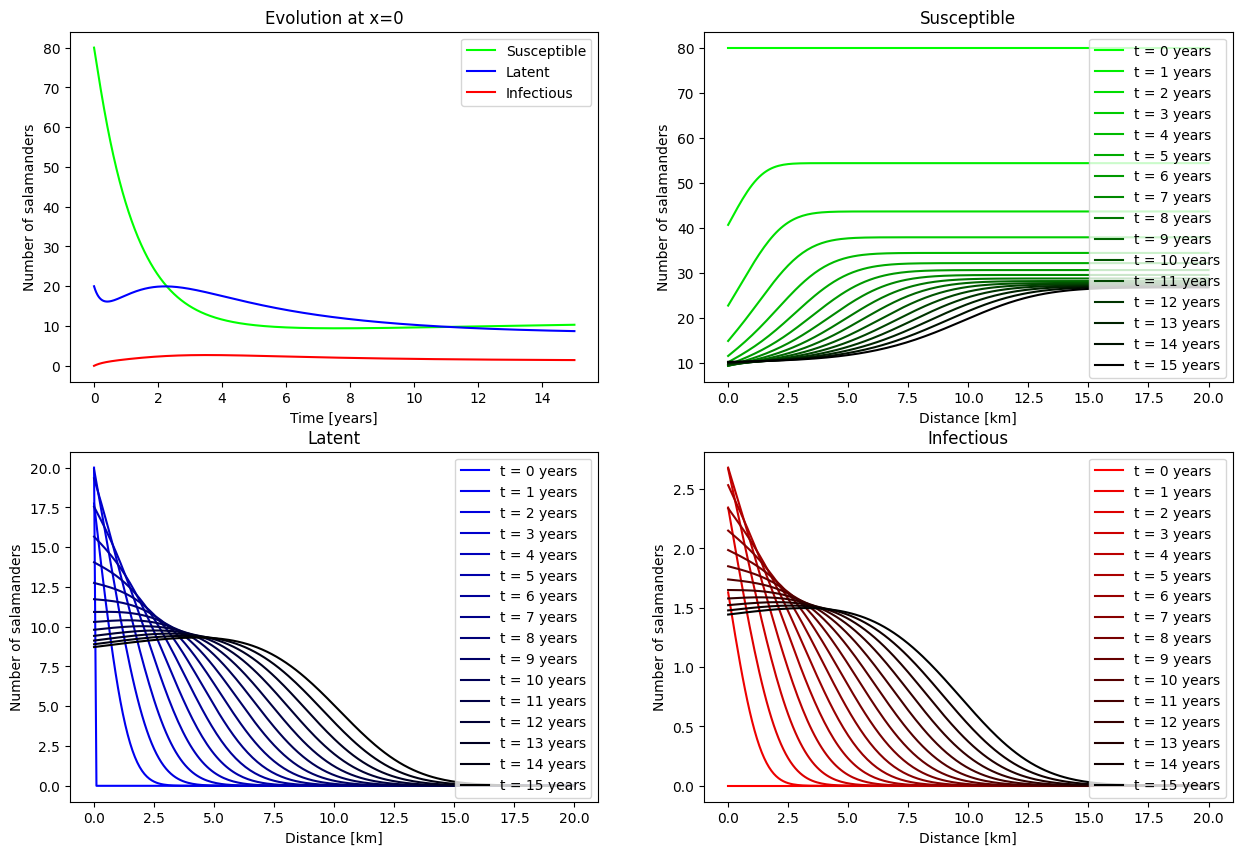

In [4]:
plot_every = 1 #year
fig, ax = plt.subplots(2,2, figsize=(15,10))

sns.lineplot(x=t, y=S[0, :], label="Susceptible", ax=ax[0, 0], color=[0, 1, 0])
sns.lineplot(x=t, y=L[0, :], label="Latent", ax=ax[0, 0], color=[0, 0, 1])
sns.lineplot(x=t, y=I[0, :], label="Infectious", ax=ax[0, 0], color=[1, 0, 0])

for year in range(max_t + 1):
    t_div_idx = int(year * (t.size - 1) / (max_t))
    sns.lineplot(x=x, y=S[:, t_div_idx],
        color=[0, np.linspace(1, 0, max_t + 1)[year], 0],
        label=f"t = {year} years",
        ax=ax[0, 1])
    sns.lineplot(x=x, y=L[:, t_div_idx],
        color=[0, 0, np.linspace(1, 0, max_t + 1)[year]],
        label=f"t = {year} years",
        ax=ax[1, 0])
    sns.lineplot(x=x, y=I[:, t_div_idx],
        color=[np.linspace(1, 0, max_t + 1)[year], 0, 0],
        label=f"t = {year} years",
        ax=ax[1, 1])

ax[0, 0].set_title("Evolution at x=0")
ax[0, 0].set_xlabel("Time [years]")
ax[0, 0].set_ylabel("Number of salamanders")
ax[0, 1].set_title("Susceptible")
ax[0, 1].set_xlabel("Distance [km]")
ax[0, 1].set_ylabel("Number of salamanders")
ax[1, 0].set_title("Latent")
ax[1, 0].set_xlabel("Distance [km]")
ax[1, 0].set_ylabel("Number of salamanders")
ax[1, 1].set_title("Infectious")
ax[1, 1].set_xlabel("Distance [km]")
ax[1, 1].set_ylabel("Number of salamanders")
plt.show()

(201, 3001)


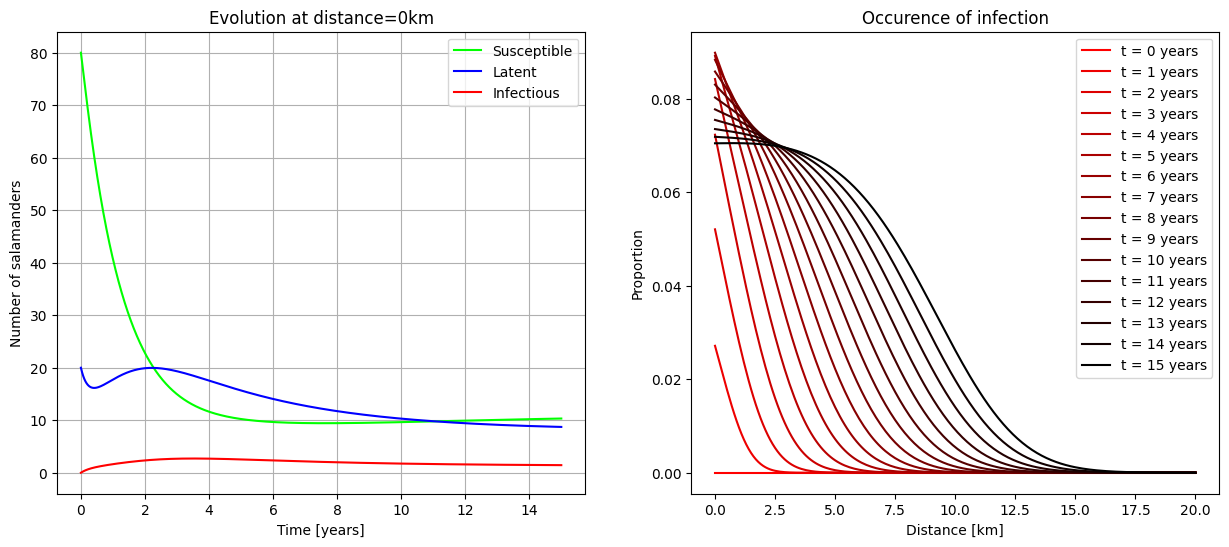

In [5]:
S_rounded = np.round(S, 5)
L_rounded = np.round(L, 5)
I_rounded = np.round(I, 5)
N_rounded = S_rounded + L_rounded + I_rounded
occurrence_infection = np.divide(
        I_rounded,
        N_rounded,
        out=np.zeros_like(I_rounded),
        where=(N_rounded != 0)
        )
print(occurrence_infection.shape)

fig, ax = plt.subplots(1,2, figsize=(15,6))

sns.lineplot(x=t, y=S[0, :], label="Susceptible", ax=ax[0], color=[0, 1, 0])
sns.lineplot(x=t, y=L[0, :], label="Latent", ax=ax[0], color=[0, 0, 1])
sns.lineplot(x=t, y=I[0, :], label="Infectious", ax=ax[0], color=[1, 0, 0])

for year in range(max_t + 1):
    t_div_idx = int(year * (t.size - 1) / (max_t))
    sns.lineplot(x=x, y=occurrence_infection[:,t_div_idx],
        color=[np.linspace(1, 0, max_t + 1)[year], 0, 0],
        label=f"t = {year} years",
        ax=ax[1])

ax[0].grid(True)
ax[0].set_title("Evolution at distance=0km")
ax[0].set_xlabel("Time [years]")
ax[0].set_ylabel("Number of salamanders")
ax[1].set_title("Occurence of infection")
ax[1].set_xlabel("Distance [km]")
ax[1].set_ylabel("Proportion")
plt.show()

In [6]:
with open('data/training_data_S.npy', 'wb') as f:
    np.save(f, S)

with open('data/training_data_L.npy', 'wb') as f:
    np.save(f, L)

with open('data/training_data_I.npy', 'wb') as f:
    np.save(f, I)

with open('data/training_data_occurence_infection.npy', 'wb') as f:
    np.save(f, occurrence_infection)